# Índice:

* [1. Introdução](#intro)
* [2. Criando Baseline](#baseline)
* [2.1 Feature Engineering](#feature)
* [2.2 Modeling e Analysis](#ma)
* [2.2.1 Treino e teste](#tt)
* [2.2.2 Cross Validation](#cv)
* [3. Feature Importance](#importance)

## 1. Introdução <a id = "intro"></a>

Antes de entrar na criação do modelo, vamos entender alguns pontos que vão ajudar a compreender o que está acontecendo na análise das métricas utilizando a matriz de confusão.

A matriz de confusão nos permite analisar de forma detalhada o comportamento do nosso classificador, e para isso ela divide os resultados em quatro tipos:

* **True Positive(TP)**: Se refere aos casos que o modelo previu corretamente a classe positiva.

* **True Negative(TN)**: Se refere aos casos que o modelo previu corretamente a classe negativa.

* **False Positivo(FP)**: Se refere aos casos onde o modelo previu que era de uma classe positiva mas na verdade era da classe negativa.

* **False Negative(FN)**: Se refere aos casos onde o modelo previu que era de uma classe negativa mas na verdade era da classe positiva.

Para exemplificar uma matriz de confusão em um problema binário, segue abaixo um exemplo.

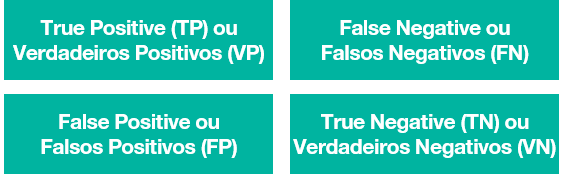

#### Métricas

Essas métricas são utilizadas para visualizar o comportamento do classificador e podemos responder algumas perguntas sobre o classificador.

* **Accuracy**: Qual a porcentagem de acertos do nosso classificador?
> $$ \frac{TP+FP}{TP+TN+FP+FN} $$

* **Precision**: Quando classifiquei como correto, quantos realmente estavam corretos?
> $$\frac{TP}{TP+FP}$$

* **Recall**: Com que frequência o classificador classifica os exemplos de uma classe? 
> $$\frac{TP}{TP+FN}$$

* **F1 Score**: É uma métrica que combina Recall e Precision com uma média harmônica, e indica a qualidade geral do modelo.
> $$\frac{2*Recall*Precision}{Recall + Precision} = \frac{\frac{1}{Precision} + \frac{1}{Recall}}{2}$$


# 2. Criando o baseline <a id = "baseline"></a>
Para a criação de um modelo inicial para nos basearmos, iremos seguir algumas etapas.

1. Feature Engineering
2. Modeling
3. Performance Analysis


In [3]:
# importando bibliotecas
import pandas as pd #Manipulação do dataframe
from asd import dataset,metrics # Importando dataset e metricas
import numpy as np # Biblioteca de calculo cientifico
import matplotlib.pyplot as plt # Biblioteca de visualização
from sklearn import tree # Biblioteca do modelo de árvore de decisão
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold # Biblioteca de separação em treino e teste e validação cruzada
from sklearn.metrics import confusion_matrix # Biblioteca que gera matriz de confusão
from sklearn.utils.multiclass import unique_labels # Biblioteca geradora das labels
import sklearn.metrics
from pprint import pprint

%matplotlib inline

In [4]:
# Criando dataframe
df = dataset.autism()
#df.set_index('id', inplace=True)
df.head()

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,NO
3,4,0,1,0,0,1,1,0,0,0,...,f,?,yes,no,Jordan,no,4,4-11 years,?,NO
4,5,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


In [5]:
# Função de plotagem da matriz de confusão
def plot_confusion_matrix(y_test,result,cmap = plt.cm.Blues):
    # Confusion matrix
    cm = confusion_matrix(y_test,result)
    classe = unique_labels(y_test,result)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classe, yticklabels=classe,
           title= 'Matriz de confusão',
           ylabel='Rótulo real',
           xlabel='Rótulo previsto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### 2.1. Feature Engineering <a id = "feature"></a>

Nessa etapa será selecionado as features que vamos utilizar no modelo baseline.

In [6]:
# Selecionando colunas com os traços comportamentais.
columns = ['A{}_Score'.format(i) for i in range(1,11)]

columns

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score']

In [7]:
# Separando em variáveis preditoras X e alvo da nossa predição Y
X = df[columns]
X

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,1,1,0,0,1,1,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0
3,0,1,0,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1
5,0,0,1,0,1,1,0,1,0,1
6,1,0,1,1,1,1,0,1,0,1
7,1,1,1,1,1,1,1,1,0,0
8,1,1,1,1,1,1,1,0,0,0
9,0,0,1,1,1,0,1,1,0,0


In [8]:
Y = df['Class/ASD']

# Para melhor entendimento do dataset, iremos renomear os valores de Y
Y = Y.replace({'NO':'Sem_Autismo','YES':'Autismo'})
Y

0      Sem_Autismo
1      Sem_Autismo
2      Sem_Autismo
3      Sem_Autismo
4          Autismo
          ...     
287        Autismo
288    Sem_Autismo
289        Autismo
290        Autismo
291    Sem_Autismo
Name: Class/ASD, Length: 292, dtype: object

### 2.2. Modeling e Analysis <a id = "ma"></a>

Nessa etapa aplicaremos o modelo que foi selecionado e com isso a contrução das predições do nosso modelo baseline.

* Modelo selecionado: Decision Tree
* Motivo: Fácil compreensão.

In [9]:
# Criação do modelo

baseline = tree.DecisionTreeClassifier()
baseline

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Nessa parte testarei duas técnicas.

* Separando em treino e teste
* Validação cruzada

#### 2.2.1. Treino e Teste <a id = "tt"></a>

In [10]:
# Separando em treino e teste
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.4,
                                                 random_state = 40)

# Treinando o modelo
test1 = baseline.fit(x_train,y_train)

results = test1.predict(x_test)
y_pred = results
table = pd.DataFrame(list(zip(y_test, y_pred)), columns=['y_test', 'y_pred'])
table.head()

,y_test,y_pred
0,Sem_Autismo,Sem_Autismo
1,Sem_Autismo,Sem_Autismo
2,Autismo,Autismo
3,Autismo,Autismo
4,Autismo,Autismo


In [11]:
print('Exemplos de Falso Negativos')
table[(table.y_test == 'Autismo') & (table.y_pred == 'Sem_Autismo')]

Exemplos de Falso Negativos


,y_test,y_pred
41,Autismo,Sem_Autismo
49,Autismo,Sem_Autismo
58,Autismo,Sem_Autismo
59,Autismo,Sem_Autismo


In [12]:
print('Exemplos de Falso Positivos')
table[(table.y_test == 'Sem_Autismo') & (table.y_pred == 'Autismo')]

Exemplos de Falso Positivos


,y_test,y_pred
17,Sem_Autismo,Autismo
24,Sem_Autismo,Autismo
37,Sem_Autismo,Autismo
43,Sem_Autismo,Autismo
87,Sem_Autismo,Autismo
88,Sem_Autismo,Autismo
96,Sem_Autismo,Autismo
101,Sem_Autismo,Autismo
107,Sem_Autismo,Autismo


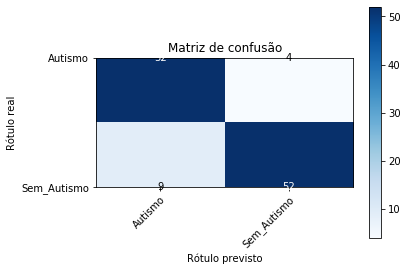

In [13]:
# Informações do modelo
plot_confusion_matrix(y_test,results)
metrics1 = metrics.classification_report(y_test, y_pred)
plt.show()

In [14]:
print("Métricas do modelo que implementamos: \n")
pprint(metrics1)
print()

print("Métricas já embutidas no sklearn: \n")
print(sklearn.metrics.classification_report(y_test, y_pred))

Métricas do modelo que implementamos: 

{'accuracy': 0.8243243243243243,
 'f1': 0.888888888888889,
 'precision': 0.8524590163934426,
 'recall': 0.9285714285714286}

Métricas já embutidas no sklearn: 

              precision    recall  f1-score   support

     Autismo       0.85      0.93      0.89        56
 Sem_Autismo       0.93      0.85      0.89        61

    accuracy                           0.89       117
   macro avg       0.89      0.89      0.89       117
weighted avg       0.89      0.89      0.89       117



#### 2.2.2. K-Fold Cross Validation <a id = "cv"></a>

A validação cruzada é uma técnica utilizada para evitar que o modelo se "acostume" com nossa base de dados e com isso não generalize novas informações.

**Funcionamento:**

Seu funcionamento se da em "dividir e testar", ou seja, os nossos dados são divididos em X partes, em cada uma dessas partes é novamente dividida em treino e teste e é testada então as partes e esse processo é repetido até que o modelo seja testado e treinado em todas essas partes e no final se calcula a métrica dos testes, dessa forma:

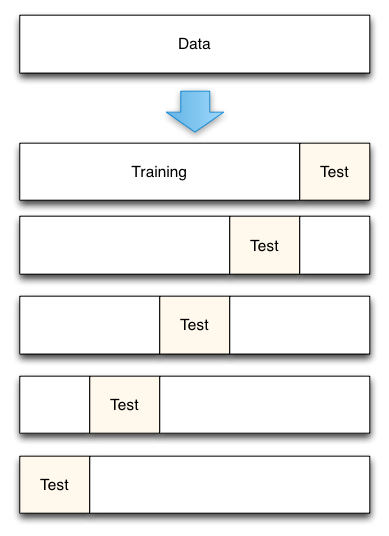

In [15]:
# Validação cruzada k-fold
#kf  = KFold(n_splits = 5, shuffle = True, random_state = 1)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
print(skf)

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)


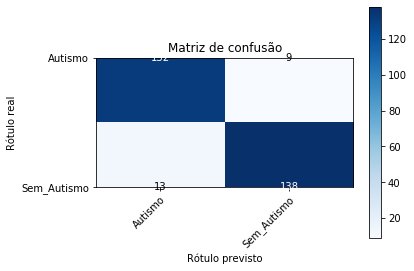

In [20]:
metricas = []
y_true = []
y_pred = []
i = 0
# Separando as bases de treino e teste
for train,test in skf.split(X,Y):
    #print(train)
    #print(test)
    # Dicionaro de treino
    train_x, test_x = X.iloc[train], X.iloc[test]
    train_y, test_y = Y.iloc[train], Y.iloc[test]
    y_true.extend(test_y.values)
    #total_y.append(test_y.values)
    #print(test_y.index.values)
    aux = baseline.fit(train_x,train_y)
    rst = aux.predict(test_x)
    y_pred.extend(rst)
    metricas.append(metrics.classification_report(test_y, rst))
    #print('Métrica do Sklearn \n  \n{}'.format(sklearn.metrics.classification_report(test_y, rst)))
    #print('Métrica implementada \n  \n{}'.format(metricas[i]))
    #plot_confusion_matrix(test_y,rst)
    i+=1
    
plot_confusion_matrix(y_true,y_pred)
plt.show()

In [17]:
# Calculo da Média e Desvio padrão das métricas
ac = np.array([metricas[x]['accuracy'] for x in range(5)])
pc = np.array([metricas[x]['precision'] for x in range(5)])
rc = np.array([metricas[x]['recall'] for x in range(5)])
f1 = np.array([metricas[x]['f1'] for x in range(5)])

# Média e devio padrão
me_ac = np.mean(ac)
std_ac = np.std(ac)

print('Accuracy - média: {} e desvio padrão:: {}'.format(me_ac,std_ac))

me_pc = np.mean(pc)
std_pc = np.std(pc)

print('Precision - média: {} e desvio padrão:: {}'.format(me_pc,std_pc))

me_rc = np.mean(rc)
std_rc = np.std(rc)

print('Recall - média: {} e desvio padrão:: {}'.format(me_rc,std_rc))

me_f1 = np.mean(f1)
std_f1 = np.std(f1)

print('F1 Score - média: {} e desvio padrão:: {}'.format(me_f1,std_f1))


Accuracy - média: 0.8526012558133301 e desvio padrão:: 0.08802523364818685
Precision - média: 0.9126451612903225 e desvio padrão:: 0.04353750560984991
Recall - média: 0.9431034482758621 e desvio padrão:: 0.05812181647823139
F1 Score - média: 0.926310333800161 e desvio padrão:: 0.03777324102267078


## 3. Feature Importance <a id ="importance"><a/>
    
Utilizar todos os atributos ao nosso alcance nem sempre é uma boa ideia, dependendo do problema isso não vai ficar legal. Então, para descobrir quais são as melhores features para criar o nosso modelo, é necessário aplicar algumas técnicas como: Qui², Importancia Gini ou Redução média da impureza, Importancia da permutação ou Redução média na precisão.

No nosso caso o modelo da biblioteca Sklearn, é baseado na Redução média da impureza.

In [18]:
dic = {i:baseline.feature_importances_[v] for v,i in enumerate(X.columns)}
dic

{'A1_Score': 0.04634368045470216,
 'A2_Score': 0.0461127770057778,
 'A3_Score': 0.07103903069309343,
 'A4_Score': 0.3526190033663077,
 'A5_Score': 0.07478308278425297,
 'A6_Score': 0.017494331894975495,
 'A7_Score': 0.09546749562416242,
 'A8_Score': 0.08777820431213404,
 'A9_Score': 0.07500951071591666,
 'A10_Score': 0.1333528831486774}

In [19]:
pd.DataFrame(list(dic.items()), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)

,feature,importance
3,A4_Score,0.352619
9,A10_Score,0.133353
6,A7_Score,0.095467
7,A8_Score,0.087778
8,A9_Score,0.075010
4,A5_Score,0.074783
2,A3_Score,0.071039
0,A1_Score,0.046344
1,A2_Score,0.046113
5,A6_Score,0.017494
